# Example: Computing Stylized Facts for Daily Equity Log Return Data
This example demonstrates the statistical analysis of financial return data by examining key stylized facts commonly observed in financial markets. We'll explore properties such as the distribution characteristics of returns, their autocorrelation patterns, and volatility clustering behavior.

> __Learning Objectives__
> 
> This example will familiarize students with computing the log growth (return) time series and analyzing some of the statistical properties of that data.
> * __Task 1__: Compute the log growth rate array. In this task, we will compute the log growth rate array for every ticker in the dataset using [the `log_growth_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix).
> * __Task 2__: Is the log growth rate normally distributed? In this task, we explore one of the central stylized facts: returns (growth) are not normally distributed.
> * __Task 3__: Autocorrelation and volatility clustering. In this task, we'll compute the autocorrelation and volatility clustering, i.e., the autocorrelation of the absolute value of the growth rate for tickers in the dataset.
>
> Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow # nrow? (check out: DataFrames.jl)

2767

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # what is this doing?
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

How many firms do we have the full number of trading days? Let's use [the `length(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.length) - notice this works for dictionaries, in addition to arrays, sets and other collections.

In [5]:
length(dataset) # tells us how many keys are in the dictionary (how many firms in our dataset?)

424

Finally, let's get a list of the firms in our cleaned dataset (and sort them alphabetically). We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [6]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

___

## Task 1: Compute the growth rate matrix
In this task, we compute the growth rate array which contains, for each day and each firm in our dataset, the value of the growth rate between time $j$ and $j-1$. 

>  __Continuously Compounded Growth Rate (CCGR)__
>
> Let's assume a model of the share price of firm $i$ is governed by an expression of the form:
>$$
\begin{align*}
S^{(i)}_{j} &= S^{(i)}_{j-1}\;\exp\left(\mu^{(i)}_{j,j-1}\Delta{t}_{j}\right)
\end{align*}
$$
> where $S^{(i)}_{j-1}$ denotes the share price of firm $i$ at time index $j-1$, $S^{(i)}_{j}$ denotes the share price of firm $i$ at time index $j$, and $\Delta{t}_{j} = t_{j} - t_{j-1}$ denotes the length of a time step (units: years) between time index $j-1$ and $j$. The value we are going to estimate is the growth rate $\mu^{(i)}_{j,j-1}$ (units: inverse years) for each firm $i$, and each time step in the dataset.

We've implemented [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix) which takes the cleaned up dataset, and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array.

In [7]:
growth_rate_array = let

    # initialize -
    Δt = (1/252); # time-step one-day in units of years (trading year is 252 days)
    r̄ = 0.0; # assume the risk-free rate is 0

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = Δt, 
        risk_free_rate = r̄); # other optional parameters are at their defaults

    growth_rate_array; # return
end

2766×424 Matrix{Float64}:
 -0.877554    6.28105    -2.87097     …  -0.755391   0.245894  -1.00527
  2.81626     1.07149     1.39239         2.13832   -0.80279    0.986468
  3.31305     0.855597    0.00536803      0.109877   1.191     -2.58144
  0.646425   17.2599      1.69215         0.274716   3.1593    -0.368228
  1.81609     2.57961     3.31924         0.621677  -2.1687     4.40309
  0.61383    -3.96384    -0.79278     …  -0.862739  -1.90977   -3.11624
  2.86071    -0.483751    4.84573         1.7657    -1.77685   -1.0896
  2.04671     1.0135      1.90809         1.67597    4.44984   -0.137819
  1.31289     1.67413     0.107259       -1.50708   -2.13696    1.43784
  1.22016     6.12957     0.932578       -1.53202    2.87784   -1.43626
  ⋮                                   ⋱                        
 -4.36889     3.84443    -2.37452        -4.26011   -9.17906   -3.94641
 -2.51182    -2.60891   -10.1209         -3.03895   -7.07468   -7.14019
  2.21355     4.15066     7.27678         3.

### Visualize
Specify a ticker symbol to explore in the `ticker_to_visualize::String` variable (this needs to be in the dataset):

In [8]:
ticker_to_visualize = "AMD";

`Unhide` the code block below to see how we plotted the daily growth rate and its distribution for the ticker specified in the `ticker_to_visualize::String` variable.
> __Growth rate__: The growth (return) data appears to be a stationary random process with non-periodic periods of extreme volatility followed by small fluctuations around the mean (which appears to be near zero). 

What do we observe?

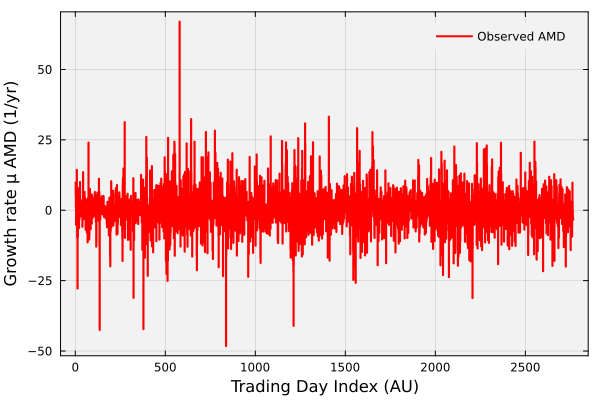

In [9]:
let
    i = findfirst(ticker -> ticker == ticker_to_visualize, list_of_tickers);
    X = growth_rate_array[:,i];

    plot(X, label="Observed $(ticker_to_visualize)", lw=2, c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost)

    xlabel!("Trading Day Index (AU)", fontsize=18);
    ylabel!("Growth rate μ $(ticker_to_visualize) (1/yr)", fontsize=18)
end

__Fat tails__: The observed growth rate data (for the example ticker specified in `ticker_to_visualize`) has a higher density near zero (many small moves) and extreme tails (low probability large moves) compared to [a normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). The observed data for this ticker _seems_ to follow [a Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution). However, other ticker symbols may be different.

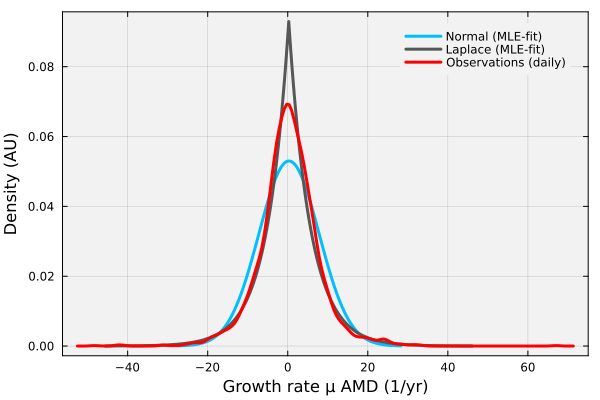

In [10]:
let
    μ = findfirst(ticker -> ticker == ticker_to_visualize, list_of_tickers) |> i -> growth_rate_array[:,i];
    
    # fit a Normal, and plot that -
    d = fit_mle(Normal, μ);
    plot(d, c=:deepskyblue1, lw = 3, label="Normal (MLE-fit)")

    # fit a Laplace, and plot that -
    d = fit_mle(Laplace, μ);
    plot!(d, c=:grey34, lw = 3, label="Laplace (MLE-fit)")
    density!(μ, c=:red, lw=3, label="Observations (daily)")

    # background -
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);

    # labels -
    xlabel!("Growth rate μ $(ticker_to_visualize) (1/yr)", fontsize=18)
    ylabel!("Density (AU)", fontsize=18);
end

Does the __return__ data follow the same distribution as the growth rate data? Let's explore that next.

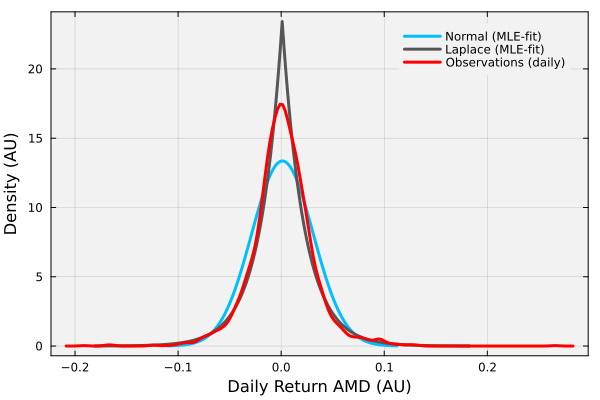

In [11]:
let

    # initialize -
    Δt = (1/252); # time-step one-day in units of years (trading year is 252 days)

    # plot -
    μ = findfirst(ticker -> ticker == ticker_to_visualize, list_of_tickers) |> i -> growth_rate_array[:,i];
    dlaplace = fit_mle(Laplace, μ*Δt) # return Laplace distribution
    dnormal = fit_mle(Normal, μ*Δt); # return Normal distribution
    plot(dnormal, c=:deepskyblue1, lw = 3, label="Normal (MLE-fit)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(dlaplace, c=:grey34, lw = 3, label="Laplace (MLE-fit)")
    density!(μ*Δt, c=:red, lw=3, label="Observations (daily)")
    
    # labels -
    xlabel!("Daily Return $(ticker_to_visualize) (AU)", fontsize=18)
    ylabel!("Density (AU)", fontsize=18);

    # save -
    # savefig("./figs/Fig-AAPL-Normal-Laplace-18-23-Return.pdf")
end

___

## Task 2: Is the growth rate normally distributed?
In this task, we explore one of the central stylized facts: returns (growth) are not normally distributed. Return distributions have fat tails, i.e., the density of the returns near zero is greater than that of a normal distribution, and there is more density on the tails of the distribution. 

> __Test:__ Let's develop a procedure based on the [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test) exported by the [HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) to estimate if the growth rate of firm $i\in\mathcal{D}$ follows a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) or [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution).

Let's look at the AD test results for the ticker specified in the `ticker_to_visualize::String` variable. What is an AD test?

> __Anderson–Darling test:__ The Anderson–Darling (AD) test is a statistical test of whether a given sample of data is drawn from a specified probability distribution. It is a type of goodness-of-fit test that compares the empirical cumulative distribution function of the sample data to the cumulative distribution function of the specified distribution. The AD test is particularly sensitive to differences in the tails of the distributions, making it useful for detecting deviations from the assumed distribution in those regions.

> __Null hypothesis:__ The Anderson–Darling test examines the null hypothesis that the data in vector $x$ come from the distribution $d$ against the alternative hypothesis that the sample is not drawn from $d$. This test reports a p-value, the probability that, assuming the null hypothesis is true (your data really are i.i.d. from $d$), the AD test statistic would be at least as extreme as the one computed from your data. 

> __TLDR:__ A small p-value or large $A^{2}$ statistic indicates that the null hypothesis is unlikely to be true, i.e., the data is unlikely to be drawn from the specified distribution $d$.

What do we see for a normal distribution?


In [12]:
let

    # initialize -
    i = findfirst(ticker -> ticker == ticker_to_visualize, list_of_tickers);
    μ = growth_rate_array[:,i];
    
    # fit the distributions (using )
    d = fit_mle(Normal, μ);

    # AD results -
    ad_test_normal = HypothesisTests.OneSampleADTest(μ, d);
end

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-06

Details:
    number of observations:   2766
    sample mean:              0.31199019785085597
    sample SD:                7.529004559121796
    A² statistic:             22.11789468980681


Now, let's consider a Laplace distribution. The Laplace distribution has a sharper peak and fatter tails than the normal distribution, which can better capture the empirical characteristics of financial returns.

In [13]:
let

    # initialize -
    pvalue_cutoff = 0.05; # significance level for the statistical tests
    i = findfirst(ticker -> ticker == ticker_to_visualize, list_of_tickers);
    μ = growth_rate_array[:,i];
    
    # fit the distributions (using )
    d = fit_mle(Laplace, μ);

    # AD results -
    ad_test_laplace = HypothesisTests.OneSampleADTest(μ, d);
end

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.0930

Details:
    number of observations:   2766
    sample mean:              0.31199019785085597
    sample SD:                7.529004559121796
    A² statistic:             1.9902494776905635


Something interesting would be to iterate through all the firms in the dataset and classify the growth rates as `Normal`, `Laplace`, or `Undefined` based on the AD test results. We'll leave that as an exercise for the reader.

Next, let's explore the Hill's estimator of the tail index $\alpha$ for the growth rate data.

In [14]:
let

    # initialize -
    growth_rate_ticker = findfirst(ticker -> ticker == ticker_to_visualize, list_of_tickers) |> i -> growth_rate_array[:,i];
    pos = filter(>(0), growth_rate_ticker)  # keep positives (make this a one-sided test)
    n = length(pos) # how many positive growth rates?
    z = sort(pos, rev=true) # sort in descending order

    tmp = Array{Float64}(undef, n-1); # temporary array
    for i ∈ 1:n-1
        tmp[i] = log(z[i]/z[n]);
    end
    value = (1/(n-1)) * sum(tmp); # Hill's estimator
    α = 1/value; # tail index

    # println -
    println("Hill's estimator of the tail index for $(ticker_to_visualize) is approximately α = $(round(α, digits=3)).");
end

Hill's estimator of the tail index for AMD is approximately α = 0.182.


___

## Task 3: Autocorrelation and volatility clustering
In this task, we'll compute the autocorrelation and volatility clustering of the growth rate for tickers in the dataset. We expect the autocorrelation to drop to zero quickly, but volatility clustering should be visible in the data.

### Autocorrelation
Let's examine the [autocorrelation as a function of the time lag](https://en.wikipedia.org/wiki/Autocorrelation) for the data in our dataset. 

`Unhide` the code block below to see how we computed and plotted the [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) for the observed dataset.
* The [random walk hypothesis](https://en.wikipedia.org/wiki/Random_walk_hypothesis) suggests that for lags greater than `1`, the autocorrelation of the return should be zero. Using the observed growth rates in the `growth_rate_array::Array{Float64,2}` array, we test this idea.
* The observed (red) growth rates show near-zero autocorrelation at a 99% confidence level as a function of the lag (day), except for a few lags in the first 20 days. Depending upon the ticker, there appears to be some correlation for a lag of approximately `7 days` in some cases.

Thus, although the data shows a few violations of the autocorrelation hypothesis, these violations are weak.

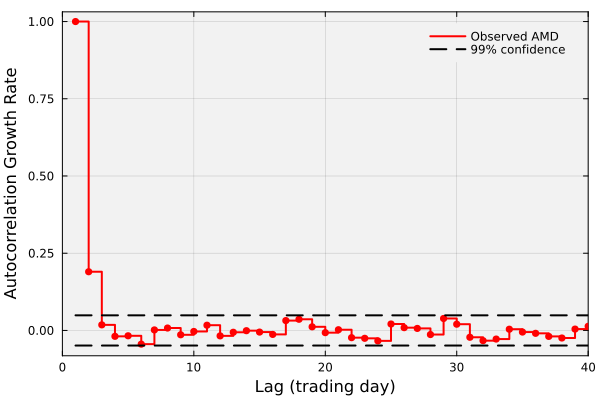

In [15]:
let

    # generate a random index -
    i = findfirst(ticker -> ticker == ticker_to_visualize,list_of_tickers);
    number_of_steps = maximum_number_trading_days - 1;
    max_number_of_steps_x = 40
    X = growth_rate_array[:,i];
    
    plot(autocor(X, (0:(number_of_steps - 1) |> collect)), label="Observed $(ticker_to_visualize)", lw=2, c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        linetype=:steppost, xlims=(0,max_number_of_steps_x))

    scatter!(autocor(X, (0:(number_of_steps - 1) |> collect)), label="", c=:red, msc=:red)
    LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation Growth Rate", fontsize=18)

    # uncomment me to save to file -
    # savefig(joinpath(_PATH_TO_FIGS, "Fig-Autocorrelation-HMM-GenModel-$(ticker).pdf"));
end

### Volatility clustering
Next, let's consider volatility clustering. Volatility clustering is determined by examining the autocorrelation of the absolute values of the growth rate for different lag values. In actual data, we expect positive absolute autocorrelation for short lags. Volatility clustering indicates that periods of high volatility, such as significant changes in returns, tend to occur close together in time.

`Unhide` the code block below to see how we computed and plotted the [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) for the absolute values of the observed growth rates.

The observed dataset (red line) shows positive autocorrelation for lags less than approximately `10 days` at a 99% confidence level. This suggests the market (or individual ticker) has a memory of approximately 10 days or less following significant disruptions.

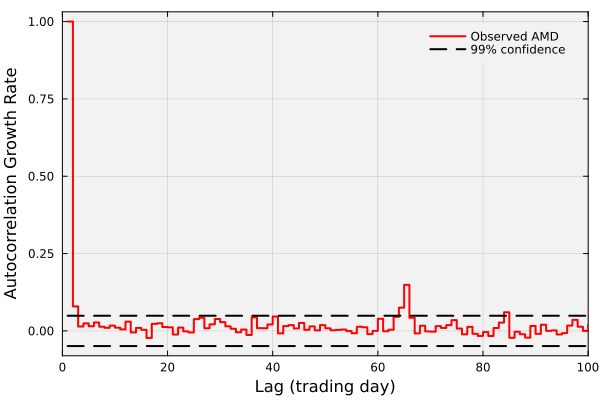

In [16]:
let

    # generate a random index -
    i = findfirst(ticker -> ticker == ticker_to_visualize,list_of_tickers);
    number_of_steps = maximum_number_trading_days - 1;
    max_number_of_steps_x = 100
    X = (growth_rate_array[:,i]).^2;

    plot(autocor(X, (0:(number_of_steps - 1) |> collect)), label="Observed $(ticker_to_visualize)", lw=2, c=:red,
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost,
    xlims=(0,max_number_of_steps_x))
    
    LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation Growth Rate", fontsize=18)

    
    # uncomment me to save to file -
    # savefig(joinpath(_PATH_TO_FIGS, "Fig-Autocorrelation-HMM-GenModel-$(ticker).pdf"));
end

___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___